## Introduction
This example will show the steps needed to build a 3D image classification
model using a 3D convolutional neural network (CNN) to predict the location
of cancerous regions in CT scans.
## Why 3D CNNs at all?
Traditional use-cases of CNNs are RGB images (3 channels). The goal of
a 3D CNN is to take as input a 3D volume or a sequence of frames
(e.g. slices in a CT scan) and extract features from it. A traditional CNN
extract representations of a single image and puts them in a vector state
(latent space), whereas a 3D CNN extracts representations of a set of images
which is required to make predictions from volumetric data (e.g. CT scans).
A 3D CNN takes the temporal dimension (e.g. 3D context) into account. This way
of learning representations from a volumetric data is useful to find the right
label. This is achieved by using 3D convolutions.

## References

- [A survey on Deep Learning Advances on Different 3D DataRepresentations](https://arxiv.org/pdf/1808.01462.pdf)

- [VoxNet: A 3D Convolutional Neural Network for Real-Time ObjectRecognition](https://www.ri.cmu.edu/pub_files/2015/9/voxnet_maturana_scherer_iros15.pdf)

- [FusionNet: 3D Object Classification Using MultipleData Representations](http://3ddl.cs.princeton.edu/2016/papers/Hegde_Zadeh.pdf)

- [Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction](https://arxiv.org/abs/2007.13224)



In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


## Downloading the  NSCLC-Radiomics-Genomics dataset
Since training 3D convolutional neural network are time consuming, a subset of the
NSCLC-Radiomics-Genomics dataset is used which consists of CT scans
with gene expression and relevant clinical data. In this example, we will be
using the "location" attribtute among the available clinical data to build a
classifier to predict cancerious regions (left or right). Hence, the task is
a binary classification problem.

In [2]:
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.1/NSCLC-Radiomics-Genomics.zip"
filename = os.path.join(os.getcwd(), "NSCLC-Radiomics-Genomics.zip")
keras.utils.get_file(filename, url)

with zipfile.ZipFile("NSCLC-Radiomics-Genomics.zip", "r") as z_fp:
    z_fp.extractall("./")

1927217152/1927209723 [==============================] - 43s 0us/step


## Load data
The files are provided in Nifti format with the extension .nii. To read the
scans, the nibabel package is used. To process the data, the following
is done:
* Volumes are originally rotated by 90 degress, so the orientation is fixed
* Resize width, height and depth

Here several helper functions are defined to process the data. These functions
will be used when building training and test datasets.

In [3]:
import numpy as np
import nibabel as nib
import cv2

from scipy.ndimage import zoom


def read_nifti_file(filepath):
    """Read and load volume"""
    # read file
    scan = nib.load(filepath)
    # get raw data
    scan = scan.get_fdata()
    # rotate
    scan = np.rot90(np.array(scan))
    return scan


def resize_slices(img):
    """Resize width and height"""
    # resize all slices
    flatten = [
        cv2.resize(img[:, :, i], (128, 128), interpolation=cv2.INTER_CUBIC)
        for i in range(img.shape[-1])
    ]
    # stack along the z-axis
    img = np.array(np.dstack(flatten))
    return img


def resize_depth(img):
    """Resize across z-axis"""
    # set the desired depth
    desired_depth = 128
    # get current depth
    current_depth = img.shape[-1]
    # compute depth factor
    depth = current_depth / desired_depth
    depth_factor = 1 / depth
    # resize across z-axis
    img_new = zoom(img, (1, 1, depth_factor), mode="nearest")
    return img_new


def process_scan(path):
    """Read and resize volume"""
    # read scan
    volume = read_nifti_file(path)
    # resize width and height
    volume = resize_slices(volume)
    # resize across z-axis
    volume = resize_depth(volume)
    return volume

Let's read the paths of the CT scans from the class directories

In [4]:
# folder "1" consist of right CT scans
right_scan_paths = [
    os.path.join(os.getcwd(), "NSCLC-Radiomics-Genomics/1", x)
    for x in os.listdir("NSCLC-Radiomics-Genomics/1")
]
# folder "2" consist of left CT scans
left_scan_paths = [
    os.path.join(os.getcwd(), "NSCLC-Radiomics-Genomics/2", x)
    for x in os.listdir("NSCLC-Radiomics-Genomics/2")
]

print("CT scans with cancerous regions in left side: " + str(len(left_scan_paths)))
print("CT scans with cancerous regions in right side: " + str(len(right_scan_paths)))

CT scans with cancerous regions in left side: 20
CT scans with cancerous regions in right side: 20


Let's visualize a CT scan and it's shape.

Dimension of the CT scan is: (512, 512, 226)


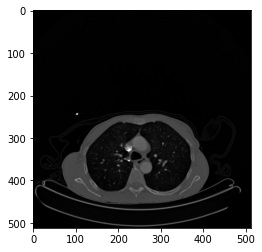

In [5]:
import matplotlib.pyplot as plt

# read a scan
img = read_nifti_file(right_scan_paths[15])
print("Dimension of the CT scan is:", img.shape)
plt.imshow(img[:, :, 150], cmap="gray")

Since a CT scan has many slices, let's visualize a montage of the slices.

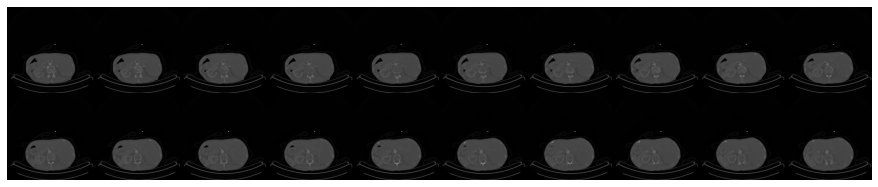

In [6]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data, columns_data, figsize=(fig_width, fig_height), gridspec_kw={"height_ratios": heights}
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# display 20 slices from the CT scan
# here we visualize 20 slices, 2 rows and 10 columns
# adapt it according to your need
plot_slices(2, 10, 512, 512,img[:, :, :20])

## Build train and test datasets
Read the scans from the class directories and assign labels.
Lastly, split the dataset into train and test subsets.

In [15]:
# read and process the scans
# each scan is resized across width, height, and depth
right_scans = np.array([process_scan(path) for path in right_scan_paths])
left_scans = np.array([process_scan(path) for path in left_scan_paths])

# for the CT scans having cancerous regions in the right side
# assign 1, similarly for left assign 0.
right_labels = np.array([1 for _ in range(len(right_scans))])
left_labels = np.array([0 for _ in range(len(left_scans))])

# split data in the ratio 70-30 for training and testing
x_train = np.concatenate((right_scans[:14], left_scans[:14]), axis=0)
y_train = np.concatenate((right_labels[:14], left_labels[:14]), axis=0)
x_test = np.concatenate((right_scans[14:], left_scans[14:]), axis=0)
y_test = np.concatenate((right_labels[14:], left_labels[14:]), axis=0)
print("Number of samples in train and test are %d and %d." 
      %(x_train.shape[0], x_test.shape[0]))

Number of samples in train and test are 28 and 12.


## Preprocessing and data augmentation
CT scans store raw voxel intensity in Hounsfield units (HU). They range from
-1024 to above 2000 in this dataset. Above 400 are bones with different
radiointensity, so this is used as a higher bound. A threshold between
-1000 and 400 are commonly used to normalize CT scans. The CT scans are
also augmented by rotating and blurring. There are different kinds of
preprocessing and augmentation techniques out there, this example shows a few
simple ones to get started.

In [123]:
import random

from scipy import ndimage
from scipy.ndimage import gaussian_filter


@tf.function(input_signature=[tf.TensorSpec(None, tf.float64)])
def tf_normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume = volume - min / max - min
    volume_min = tf.reduce_min(volume)
    volume_max = tf.reduce_max(volume)
    normalized_volume = (volume - volume_min) / (volume_max - volume_min)
    normalized_volume = tf.expand_dims(normalized_volume, axis=3)
    return normalized_volume


@tf.function(input_signature=[tf.TensorSpec(None, tf.float64)])
def tf_rotate(volume):
    """Rotate the volume by some degrees"""
    def rotate(volume):
      # define some rotation angles
      angles = [-20, -10, -5, 5, 10, 20]
      # pick angles at random
      angle = random.choice(angles)
      # rotate volume
      volume = ndimage.rotate(volume, angle, reshape=False)
      return volume
    augmented_volume = tf.numpy_function(rotate, [volume], tf.float64)
    return augmented_volume


@tf.function(input_signature=[tf.TensorSpec(None, tf.float64)])
def tf_blur(volume):
    """Blur the volume"""
    def blur(volume):
      # gaussian blur
      volume = gaussian_filter(volume, sigma=1)
      return volume
    augmented_volume = tf.numpy_function(blur, [volume], tf.float64)
    return augmented_volume


def train_preprocessing(volume, label):
    "Process training data by rotating, blur and normalizing"
    # define the augmentation functions
    augmentations = [tf_rotate, tf_blur]
    # pick an augmentation at random
    augmentation = random.choice(augmentations)
    # augment data
    volume = augmentation(volume)
    # normalize
    volume = tf_normalize(volume)
    return volume, label


def test_preprocessing(volume, label):
  "Process test data by only normalizing"
  volume = tf_normalize(volume)
  return volume, label

While defining the train and test data loader, the training data is passed through and augmentation function which randomly rotates or blurs the volume and finally rescales it to have values between 0 to 1. 

For the test data, the volumes are only rescaled.

In [124]:
# define data loaders
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 2
# augment the on the fly during training
train_dataset = train_loader.shuffle(len(x_train)).map(train_preprocessing).batch(batch_size)
# only rescale
test_dataset = test_loader.shuffle(len(x_test)).map(test_preprocessing).batch(batch_size)

Visualize an augmented CT scan

Dimension of the CT scan is: (128, 128, 128, 1)


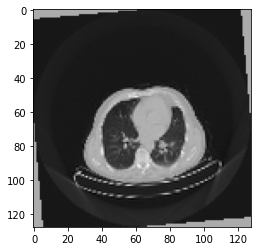

In [125]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:,:,80]), cmap="gray")

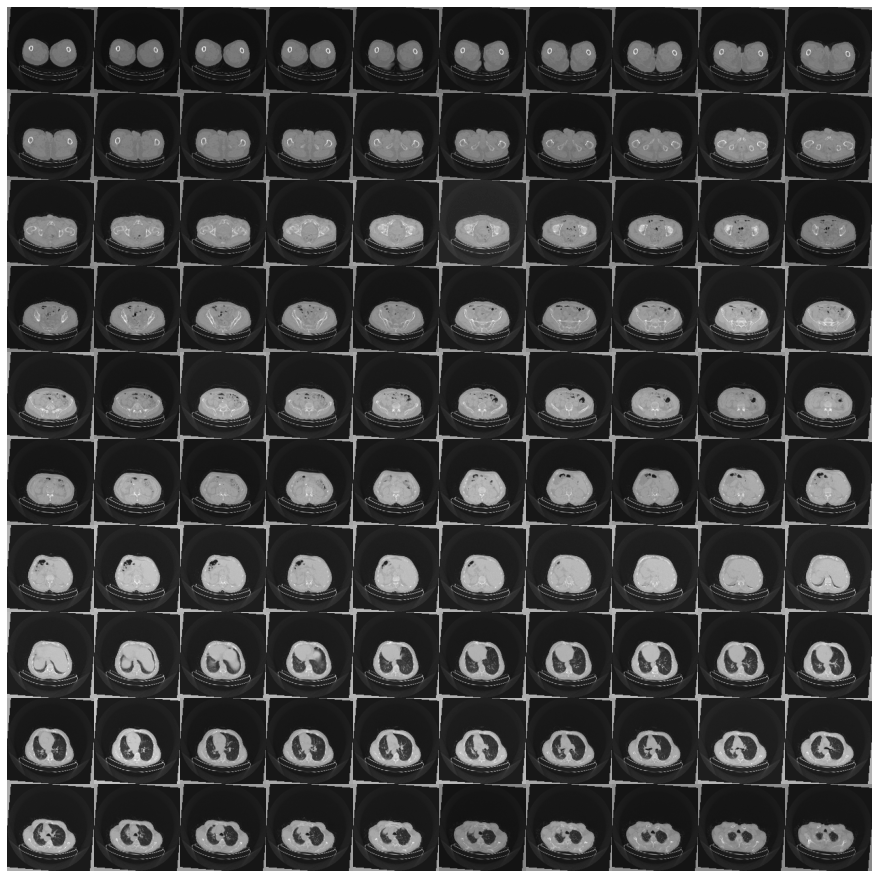

In [126]:
# visualize montage of slices
# 10 rows and 10 columns for 100 slices of the CT scan
plot_slices(10, 10, 128, 128,image[:, :, :100])

## Define 3D convolutional neural network



To make the model easier to understand, blocks are defined. Since this is a
3D CNN, 3D convolutions are used. The architecture of the 3D CNN used in this example
is based on this [paper](https://arxiv.org/abs/2007.13224).

In [130]:
def get_model(width=128, height=128, depth=128):
    """build a 3D convolutional neural network model"""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)  

    x = layers.Conv3D(filters=128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=512, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=512, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation='sigmoid')(x)

    # define the model
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

# build model
model = get_model(width=128, height=128, depth=128)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 128, 1) 0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 126, 126, 126, 64) 1792      
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 63, 63, 63, 64)    0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 63, 63, 63, 64)    256       
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 61, 61, 61, 128)   221312    
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 30, 30, 30, 128)   0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 30, 30, 30, 128)   512   

## Train model

In [131]:
# compile model
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=["acc"]
)

# define callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint("3d_image_classification.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=10)

# train the model, doing validation at the end of each epoch.
epochs = 100
model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb,early_stopping_cb],
)

Epoch 1/100
14/14 - 17s - loss: 1.0659 - acc: 0.6071 - val_loss: 0.7875 - val_acc: 0.5000
Epoch 2/100
14/14 - 17s - loss: 0.7731 - acc: 0.6429 - val_loss: 0.7615 - val_acc: 0.5000
Epoch 3/100
14/14 - 17s - loss: 0.8128 - acc: 0.6786 - val_loss: 0.8890 - val_acc: 0.5000
Epoch 4/100
14/14 - 17s - loss: 0.8091 - acc: 0.5000 - val_loss: 0.9312 - val_acc: 0.5000
Epoch 5/100
14/14 - 17s - loss: 0.6691 - acc: 0.5714 - val_loss: 0.7992 - val_acc: 0.5000
Epoch 6/100
14/14 - 17s - loss: 0.7558 - acc: 0.5357 - val_loss: 0.9108 - val_acc: 0.5000
Epoch 7/100
14/14 - 17s - loss: 0.6463 - acc: 0.7857 - val_loss: 0.6895 - val_acc: 0.5000
Epoch 8/100
14/14 - 17s - loss: 0.6261 - acc: 0.6071 - val_loss: 0.7151 - val_acc: 0.5000
Epoch 9/100
14/14 - 17s - loss: 0.6837 - acc: 0.6071 - val_loss: 0.9505 - val_acc: 0.5000
Epoch 10/100
14/14 - 17s - loss: 0.5556 - acc: 0.7143 - val_loss: 0.7323 - val_acc: 0.5000
Epoch 11/100
14/14 - 17s - loss: 0.7037 - acc: 0.5714 - val_loss: 1.0088 - val_acc: 0.5000


It is important to note that the number of sample are really small (only 40) and no
random seed is specified. You can expect large variances in your results. It is also a good
exersize to try other parameters and see what works!

## Visualizing model performance


Here the model accuracy and loss for the training and the validation sets are plotted. Since
the test set is class-balanced, accuracy provides an unbiased representation of the
errors.

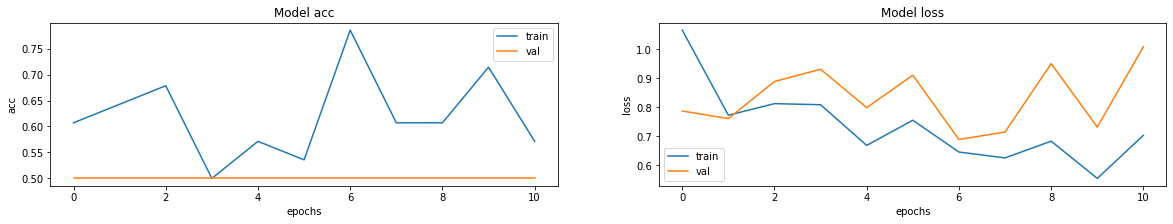

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[met])
    ax[i].plot(model.history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])


### Make predictions on a single CT scan

In [133]:
# load best weights
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_test[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

CLASS_NAMES = ["left", "right"]
for score, name in zip(scores, CLASS_NAMES):
    print("This model is %.2f percent confident that cancer in the %s side" %((100 * score), name))

This model is 0.00 percent confident that cancer in the left side
This model is 100.00 percent confident that cancer in the right side
